# Peak method applied to NN
The script takes the ECG datasets and for every sample extracts relevant peaks which are then used to train the Neural Network

In [1]:
# Importing packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# Load data from file and generate training, test and validation sets

DATA_SPLIT = 0.1
SEED = 12345

# Read files
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

train_df_x = train_df.iloc[:,:186].values
train_df_y = train_df[187]
set_train, set_valid, target_train, target_valid = train_test_split(train_df_x, train_df_y, test_size=DATA_SPLIT, random_state=SEED)
#train_df, valid_df = train_test_split(train_df, test_size=DATA_SPLIT, random_state=SEED)

set_test=test_df.iloc[:,:186].values
target_test=test_df[187]

y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
y_valid=to_categorical(target_valid)

num_train = len(y_train)
num_test = len(y_test)
num_valid = len(y_valid)


# Separate signal data from category

target_train=train_df[187]
target_test=test_df[187]
target_valid=valid_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
y_valid=to_categorical(target_valid)
set_train=train_df.iloc[:,:186].values
set_test=test_df.iloc[:,:186].values
set_valid=valid_df.iloc[:,:186].values


In [3]:
# Combine train and test data for preprocessing

v_data = np.append(set_train,set_test, 0)
v_data = np.append(v_data, set_valid, 0)
v_result = np.append(y_train, y_test, 0)
v_result = np.append(v_result, y_valid, 0)
print(len(v_data))

109446


In [4]:
# Define time array

v_time = np.arange(0, len(v_data[0]), 1, dtype=int)

In [5]:
# Calculate moving averages

# Window size for moving averages
LOWPASS_WINDOW = 3

v_data_lp = np.zeros_like(v_data)
#tmp_lowpass = np.zeros_like(v_data)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for i in range(0, len(v_data)):
    tmp_lowpass = moving_average(v_data[i], LOWPASS_WINDOW)
    v_data_lp[i] = np.pad(tmp_lowpass, (LOWPASS_WINDOW-1,0), 'constant', constant_values=(tmp_lowpass[0],0))

In [6]:
# Zeros array for x-axis

axis_x = np.zeros_like(v_data[0])

In [7]:
# Identify potential peaks
# Compare 3 signal samples S0, S1, S2
# Peak if:  S1>=S0 and S1>S2
#           S1<=S0 and S1<S2

DELTA_PEAK = 0.03       # Minimum signal amplitude from one peak to the next
DELTA_TIME = 35         # Maximum time after a peak in which DELTA_PEAK is considered (after this time peaks with any amplitude are considered)

v_peaks_data = np.zeros_like(v_data_lp)
v_peaks_time = np.zeros_like(v_data_lp)
#j = 0

for n in range(len(v_data_lp)):
    j = 0
    # Walk through all samples
    for i in range(1, len(v_data_lp[n])-1):
        # Identify peak
        if  ((v_data_lp[n][i] >= v_data_lp[n][i-1]) and (v_data_lp[n][i] > v_data_lp[n][i+1])) or \
            ((v_data_lp[n][i] <= v_data_lp[n][i-1]) and (v_data_lp[n][i] < v_data_lp[n][i+1])):
            # Check if peak value amd time
            if  (abs(v_data_lp[n][i] - v_peaks_data[n][j-1]) > DELTA_PEAK) or \
                (abs(v_time[i] - v_peaks_time[n][j-1]) > DELTA_TIME):
                #print("n:", str(n), " i:", str(i), " j:", str(j))
                v_peaks_data[n][j] = v_data_lp[n][i]
                v_peaks_time[n][j] = v_time[i]
                j += 1

#v_peaks_data[n] = v_peaks_data[n][v_peaks_time[n] != 0]
#v_peaks_time[n] = v_peaks_time[n][v_peaks_time[n] != 0]

In [8]:
# Delete samples with too many peaks

MAX_PEAK_NUM = 240       # Maximum peaks for each array

n_offset = 0
delta_num_train = 0
delta_num_test = 0
delta_num_valid = 0
del_peak_cat = [0,0,0,0,0]      # Log the category of each deleted peak

print('Samples before peak check: ' + str(len(v_peaks_data)))

for n in range(len(v_peaks_data)):
    index = n-n_offset
    if len(v_peaks_data[index][v_peaks_time[index] != 0]) > MAX_PEAK_NUM:
        # Delete from peak set
        v_peaks_data = np.delete(v_peaks_data, index, 0)
        v_peaks_time = np.delete(v_peaks_time, index, 0)
        # Delete from category set
        del_peak_cat = del_peak_cat + v_result[index]
        v_result = np.delete(v_result, index, 0)
        # Delete from samples set
        v_data_lp = np.delete(v_data_lp, index, 0)
        
        n_offset += 1
        if n < num_train:
            delta_num_train += 1
        elif n < num_train+num_test:
            delta_num_test += 1
        else:
            delta_num_valid += 1

num_train -= delta_num_train
num_test -= delta_num_test
num_valid -= delta_num_valid

print('Samples after peak check: ' + str(len(v_peaks_data)))
print('Categories: ')
print(del_peak_cat)

Samples before peak check: 109446
Samples after peak check: 109446
Categories: 
[0, 0, 0, 0, 0]


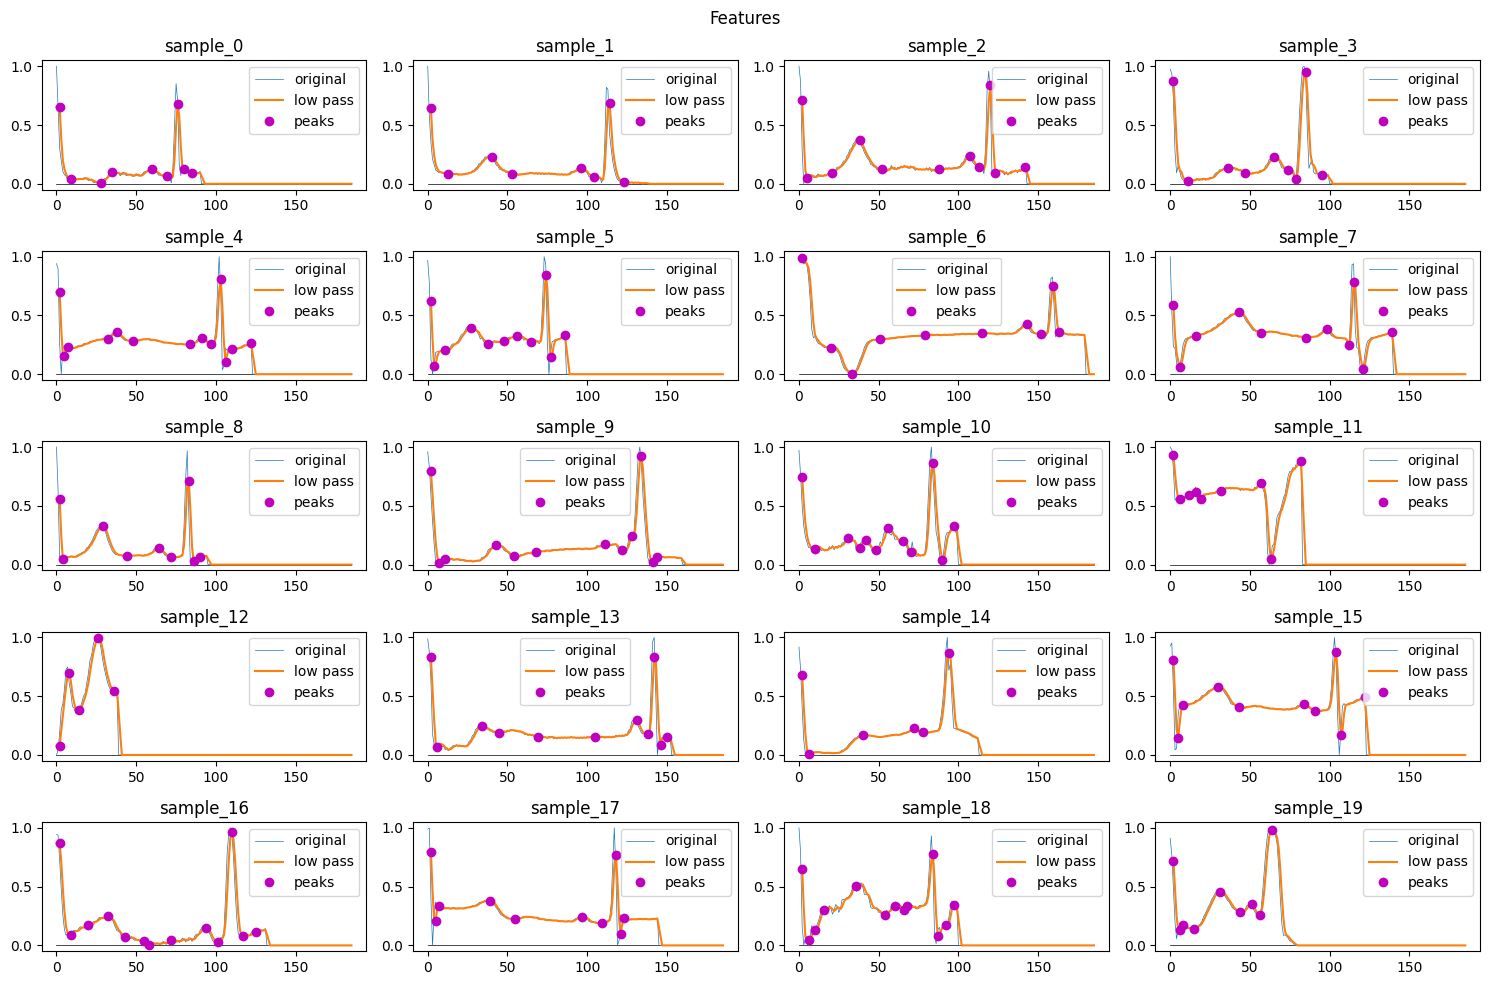

In [9]:
# Plot results
N_ROW = 5
N_COL = 4

fig, axs = plt.subplots(N_ROW, N_COL)
fig.set_size_inches(15, 2*N_ROW)
fig.suptitle("Features")
for i, ax in enumerate(axs.flatten()):
    ax.title.set_text('sample_'+str(i))
    ax.plot(axis_x, linewidth=0.5, color="black")
    ax.plot(v_data[i], linewidth=0.5, label="original")
    ax.plot(v_time, v_data_lp[i], label="low pass")

    v_peaks_data_plot = v_peaks_data[i][v_peaks_time[i] != 0]
    v_peaks_time_plot = v_peaks_time[i][v_peaks_time[i] != 0]
    ax.plot(v_peaks_time_plot, v_peaks_data_plot, 'mo', label="peaks")
    ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# Create array combining peak amplitudes and peak times

# Find maximum length of peaks arrays
peak_length = np.zeros(len(v_peaks_data))
for i in range(len(v_peaks_data)):
    peak_length[i] = len(v_peaks_data[i][v_peaks_time[i] != 0])

max_length = int(np.max(peak_length))
peak_avg = np.ones(len(peak_length))*np.mean(peak_length)


# Define structure of arrays
input_peaks = np.zeros((len(v_peaks_data),2*max_length))

# Fill strcuture with peaks data
# P0,dT0,P1,dT1,P2,dT2...,Pn,Tn  
# with Px: peak amplitude, Tx: delta time from previous peak
for n in range(len(v_peaks_data)):
    prev_time = 0
    tmp_data = v_peaks_data[n][v_peaks_time[n] != 0]
    tmp_time = v_peaks_time[n][v_peaks_time[n] != 0]
    for i in range(0,len(tmp_data)):
        # Copy peaks to structure
        input_peaks[n][2*i] = tmp_data[i]
        input_peaks[n][2*i+1] = tmp_time[i] - prev_time
        prev_time = tmp_time[i]


<function matplotlib.pyplot.show(close=None, block=None)>

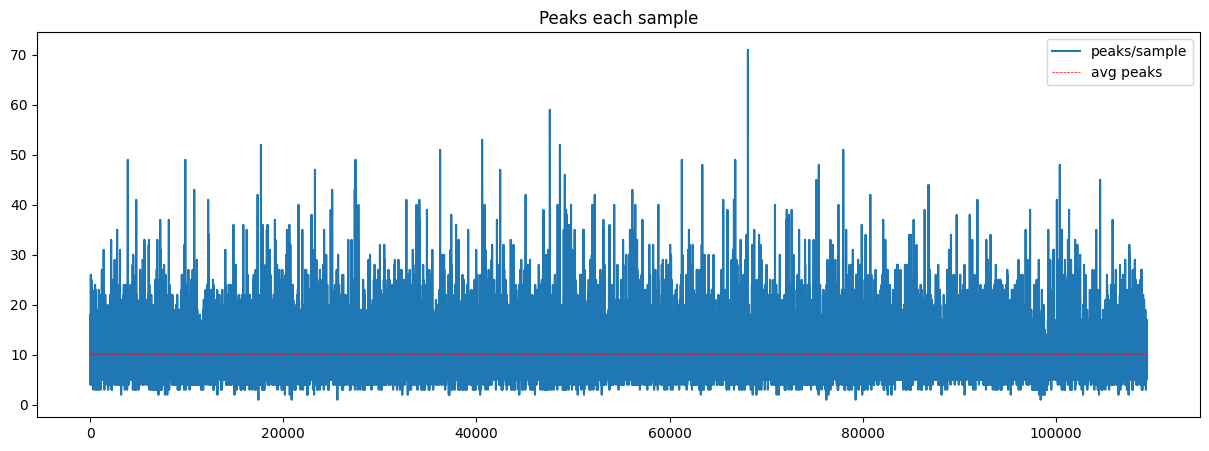

In [11]:
# Plot peaks data for all samples

plt.rcParams["figure.figsize"] = (15,5)
plt.title('Peaks each sample')
plt.plot(peak_length, label="peaks/sample")
plt.plot(peak_avg, 'r--', linewidth=0.5, label='avg peaks')
plt.legend()
plt.show
#print(v_data[max_sample])

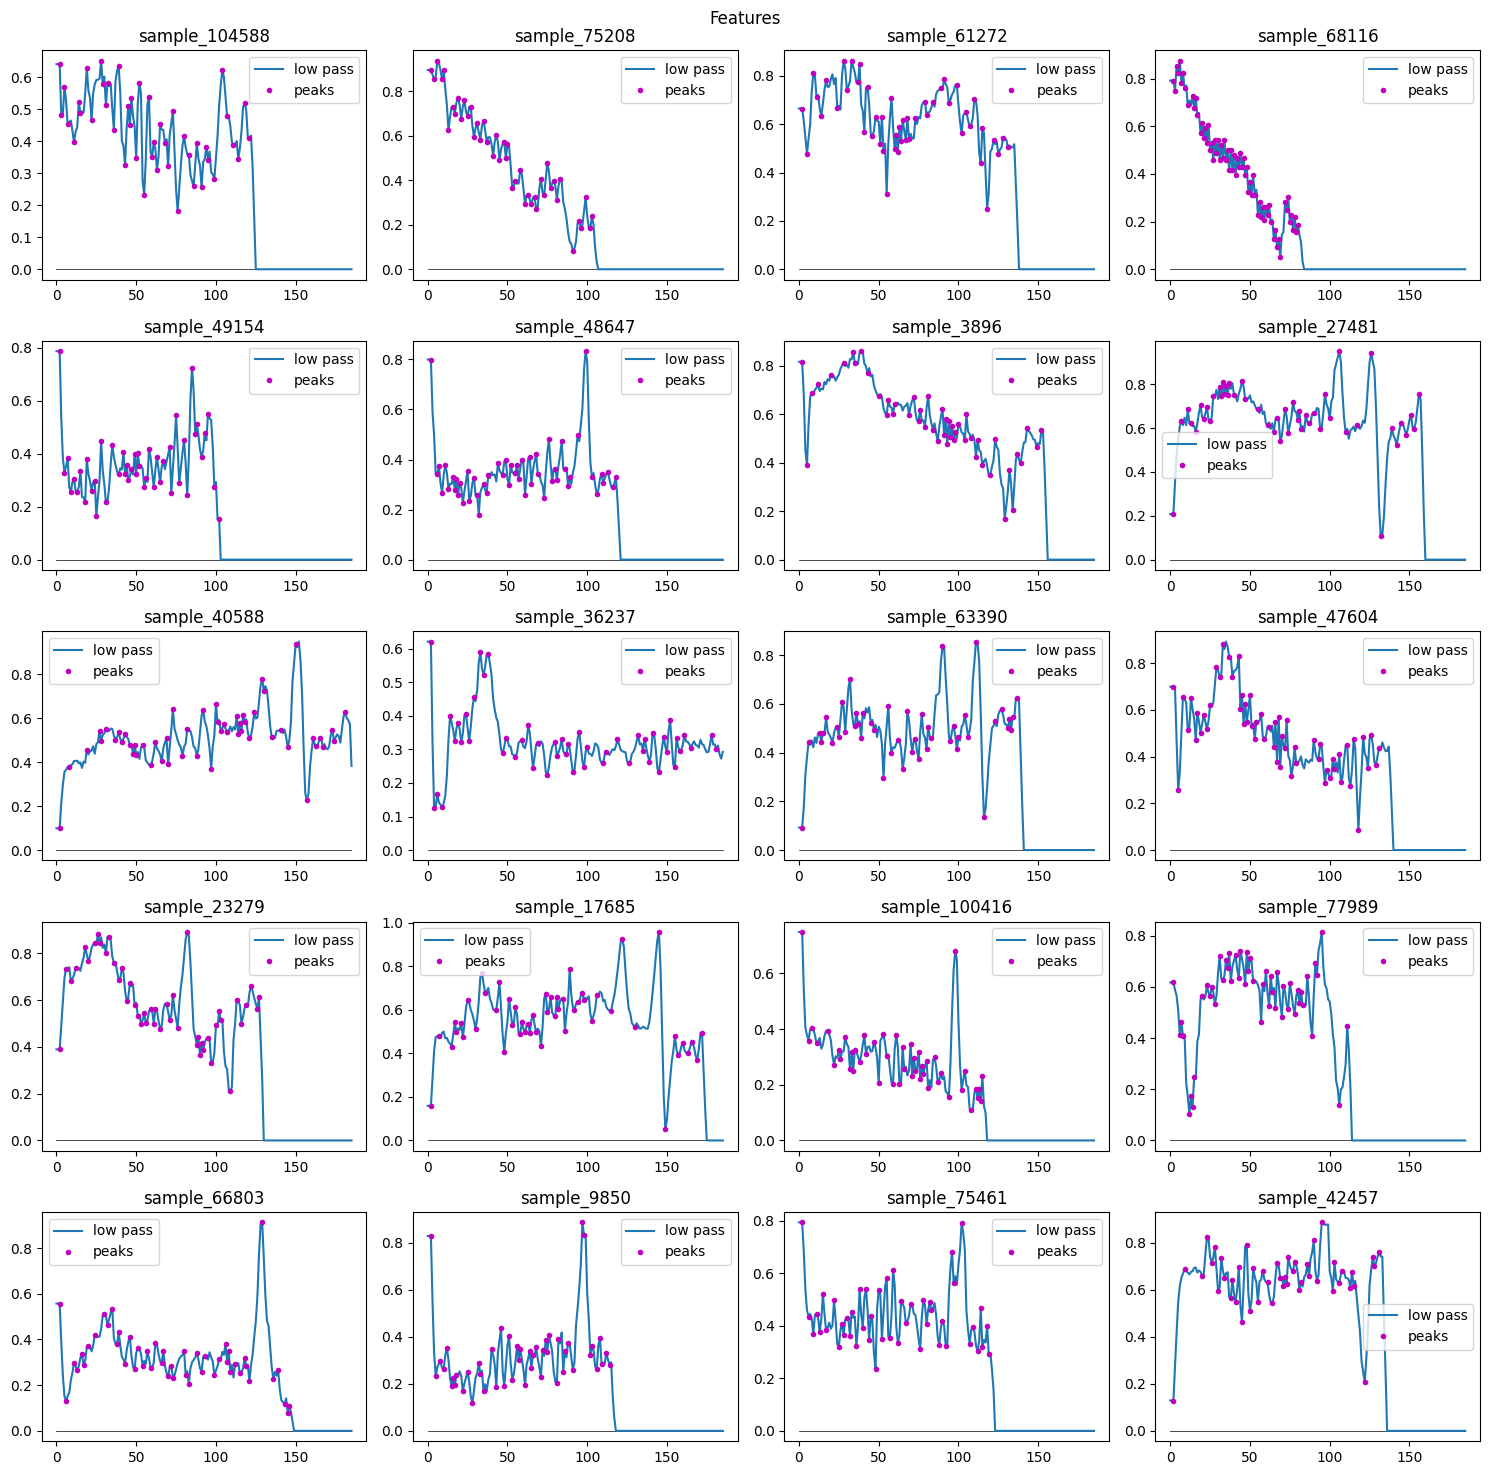

In [12]:
# Plot samples with high number of peaks
N_ROW = 5
N_COL = 4
N_TOT = N_ROW*N_COL

max_index = np.argpartition(peak_length, -N_TOT)[-N_TOT:]

fig, axs = plt.subplots(N_ROW, N_COL)
fig.set_size_inches(15, 15)
fig.suptitle("Features")
for n, ax in enumerate(axs.flatten()):
    i = max_index[n]
    ax.title.set_text('sample_'+str(i))
    ax.plot(axis_x, linewidth=0.5, color="black")
    ax.plot(v_data_lp[i], label="low pass")

    v_peaks_data_plot = v_peaks_data[i][v_peaks_time[i] != 0]
    v_peaks_time_plot = v_peaks_time[i][v_peaks_time[i] != 0]
    ax.plot(v_peaks_time_plot, v_peaks_data_plot, 'm.', label="peaks")
    #ax.plot(peak_length[i]*np.ones_like(v_data_lp[i]), 'r--', linewidth=0.5)
    ax.legend()
plt.tight_layout()
plt.show()

In [13]:
# Separate train and test data after processing

x_train = input_peaks[range(0, num_train, 1)]
x_test = input_peaks[range(num_train, num_train+num_test, 1)]
x_valid = input_peaks[range(num_train+num_test, num_train+num_test+num_valid, 1)]

y_train = v_result[range(0, num_train, 1)]
y_test = v_result[range(num_train, num_train+num_test, 1)]
y_valid = v_result[range(num_train+num_test, num_train+num_test+num_valid, 1)]

#print(v_result)
#print(x_train)
#y_train


In [14]:
# Define NN structure
im_shape=(input_peaks[0].shape[0],1)
print(im_shape)
model = Sequential([
    Input(shape=(im_shape), name='inputs_cnn'),
    #Convolution1D(1, (3), strides=1, padding="same", activation='relu'),
    #MaxPool1D(2),
    #Convolution1D(1, (5), strides=3, activation='relu'),
    #MaxPool1D(2),
    Flatten(),
    Dense(30, activation='relu'),
    Dense(5, activation='softmax', name='main_output') 
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

(142, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 142)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         4,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,445 (17.36 KB)

 Trainable params: 4,445 (17.36 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training parameters
EPOCH_NUM = 20
BATCH_SIZE = 32

# Train model
history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid))
#history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid), callbacks=[tensorboard_callback])


Epoch 1/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7853 - loss: 0.8625 - val_accuracy: 0.8835 - val_loss: 0.4178
Epoch 2/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8844 - loss: 0.4131 - val_accuracy: 0.8973 - val_loss: 0.3670
Epoch 3/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8957 - loss: 0.3656 - val_accuracy: 0.9075 - val_loss: 0.3386
Epoch 4/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9043 - loss: 0.3358 - val_accuracy: 0.9117 - val_loss: 0.3207
Epoch 5/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9120 - loss: 0.3142 - val_accuracy: 0.9145 - val_loss: 0.3134
Epoch 6/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9161 - loss: 0.3004 - val_accuracy: 0.9199 - val_loss: 0.2990
Epoch 7/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9205 - loss: 0.2931 - val_accuracy: 0.9228 - val_loss: 0.2992
Epoch 8/20
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9219 - loss: 0.2838 - 

In [16]:
y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)

# Create confusion matrix and normalize it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
classes = [0,1,2,3,4]
result_norm = np.around(result, 4)
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion matrix
        0       1       2       3       4
0  0.9467  0.1812  0.1276  0.1489  0.0159
1  0.0214  0.7625  0.0224  0.0000  0.0007
2  0.0188  0.0562  0.7858  0.2979  0.0269
3  0.0043  0.0000  0.0209  0.5426  0.0021
4  0.0088  0.0000  0.0433  0.0106  0.9545

Average accuracy
0.7984079009667738


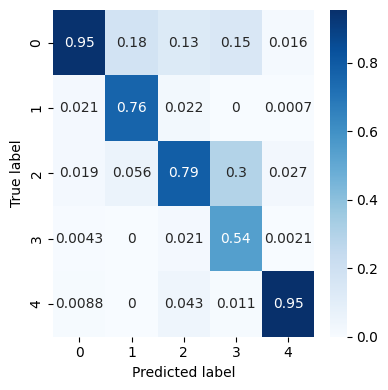

In [17]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
#plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()